## Computer Vision and Deep Learning 
## Lab 2.a - Mono Camera Calibration Example
This lab looks into calibrating camera systems. To this end we want to utilise corresponding points within a set of images to help identify intrinsic parameters linking the cameras in the real-world.

There are two ways to approach this lab. You can either grab the calibration board from the front and grab a series of images from the KinectV2 using code similar to the first lab, or you can utilise the data I have captured myself. Both will then be used in the same way later on, but it may be nice to have a bit of personalisation for the data you will be using.

First we need to obtain some images, identify a checkerboard pattern on the RGB image maps and then register the points identifed on the checkerboard across the different images. 

We will utilize OpenCV functionality to undertake a large portion of the pipeline, however I will also give a brief insight into the more hands-on approach that we can take (but this will be in MATLAB). 

## Imports <a id="imports"></a>
The following section defines the imports used for the rest of the notebook.

In [1]:
# For ndarray handling:
import numpy as np

# For plotting:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [9, 10]

# For TCP/IP functionality:
from struct import unpack
import socket

# For image processing applications
import cv2

# For saving images
from PIL import Image

# For Operating System tools and file finding
import os
import glob

# Grab calibration images.
We can either grab some calibration images from the KinectV2 in a similar fashion to last lab, or we can simply load some example data from disk. Change the `capture_new` flag to switch.

In [2]:
n_frames = 0 # Edit this to select your number of requested frames
img = []
dep = []
infra = []

capture_new = True #Changed from false. True to get images from Kinect

# A function to get our messages over TCP/IP
def getMessage(sock, data_type):
    msg_size = sock.recv(8)
    (msg_size,) = unpack('>Q', msg_size)
    data = b''
    while len(data) < msg_size:
        left_to_read = msg_size - len(data)
        data += sock.recv(8192 if left_to_read > 8192 else left_to_read)
    data = np.frombuffer(data, data_type)
    sock.send(b'1')
    return data


# Get images from either disk or over TCP/IP
if capture_new: # Get data over TCP/IP
    server_ip = '137.44.6.201' # Edit this to reflect the correct IP address
    server_port = 20156
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect((server_ip, server_port))
    
    request_frame = True
    while request_frame:
        print('Getting frame: {0}'.format(n_frames))
        s.send(bytes([1]))

        # Get color
        img.append(getMessage(s, np.uint8))
        # Get depth
        dep.append(getMessage(s, np.uint16))
        # Get infrared
        infra.append(getMessage(s, np.uint8))

        print('Frame {0} done'.format(n_frames))
        n_frames += 1
        
        print('Type q and press enter to stop collecting frames:')
        if input() == 'q':
            request_frame = False

    print('Finished grabbing data from server.')
    s.close()
    
else: # Get data from disk
    path_to_data = os.getcwd() # Edit this if data is another directory
    data_files = glob.glob(path_to_data + '\KinectV2_Image_frame*.npy')
    n_frames = np.max([int(elem[-6:-4]) for elem in data_files]) + 1
    
    for i_frame in range(n_frames):
        print('Getting frame: {0}'.format(i_frame))
        img.append(np.load('KinectV2_Image_frame{0:02d}.npy'.format(i_frame)))
        dep.append(np.load('KinectV2_Depth_frame{0:02d}.npy'.format(i_frame)))
        infra.append(np.load('KinectV2_Infra_frame{0:02d}.npy'.format(i_frame)))
    
    print('Finished grabbing data from disk.')

Getting frame: 0
Frame 0 done
Type q and press enter to stop collecting frames:

Getting frame: 1
Frame 1 done
Type q and press enter to stop collecting frames:

Getting frame: 2
Frame 2 done
Type q and press enter to stop collecting frames:

Getting frame: 3
Frame 3 done
Type q and press enter to stop collecting frames:

Getting frame: 4
Frame 4 done
Type q and press enter to stop collecting frames:
q
Finished grabbing data from server.


## Reshape the data packets into 2D maps
The byte streams coming in over the TCP/IP connection are a flattened form of the color, depth and infrared maps captured by the KinectV2. We therefore want to reshape these vectors into their original shapes. For the color maps we require a `Height` $\times$ `Width` $\times$ `Channel` ndarray, depth and infrared maps both require a `Height` $\times$ `Width` ndarray.

The native KinectV2 color map resolution is `Height`: 1920, `Width`: 1080 and `Channel`: 4 (BGRA - Blue, Green, Red, Alpha), but the depth and infrared maps are `Height`: 424, `Width`: 512.

In [3]:
# Reshape the frames
# Halfed the resolution so we can transfer them easier

IMGW = 1920 // 2  # Image width
IMGH = 1080 // 2  # Image Height
DEPW = IMGW #512
DEPH = IMGH #524
INFRAW = DEPW
INFRAH = DEPH
img = [np.reshape(elem,(IMGH, IMGW, -1)) for elem in img]
dep = [np.reshape(elem,(DEPH, DEPW)) for elem in dep]
infra = [np.reshape(elem,(INFRAH, INFRAW)) for elem in infra]

## Save the new captures if needed.
Save both the numpy array information, and the appearance pngs for later if wanted.

In [4]:
save_data = False
if save_data:
    for i_frame in range(n_frames):
        np.save('KinectV2_Image_frame{0:02d}.npy'.format(i_frame), img[i_frame])
        np.save('KinectV2_Depth_frame{0:02d}.npy'.format(i_frame), dep[i_frame])
        np.save('KinectV2_Infra_frame{0:02d}.npy'.format(i_frame), infra[i_frame])
        
        im = Image.fromarray(img[i_frame][:, :, [2, 1, 0]])
        im.save("KinectV2_Image_frame{0:02d}.png".format(i_frame))
        

## Color channel correction
Notice that the Kinect returns the color channels in BGRA order. For `matplotlib`'s image plotting functionality we will want to pass the channels in RGB order, for this we slice into our color map and reorder the channel dimension with `[:, :, [2, 1, 0]]`.

In [5]:
for i_frame in range(n_frames): # changed from n_frames
    print(i_frame)
    img[i_frame] = img[i_frame][:, :, [2, 1, 0]]

0
1
2
3
4


## Plot frames
In this following section we want to plot the color, depth and infrared maps we have collected from the KinectV2. 

Note that these maps do not match eachother exactly, pixels within the color map do not correspond directly to the corresponding pixel in the depth and infrared maps. The sensors on the KinectV2 are mounted at opposite ends of the sensor bar, and have differing resolutions and fields of view. 

This difference in viewpoint means that in order to align (or more formally ''register'') the color to the depth map we need to calculate the intrinsic and extrinsic parameters of the numerous Kinect sensors, we will cover this in the coming labs.

<IPython.core.display.Javascript object>


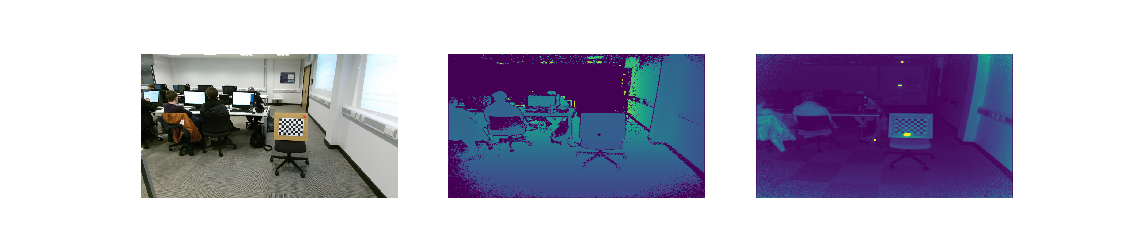

<IPython.core.display.Javascript object>


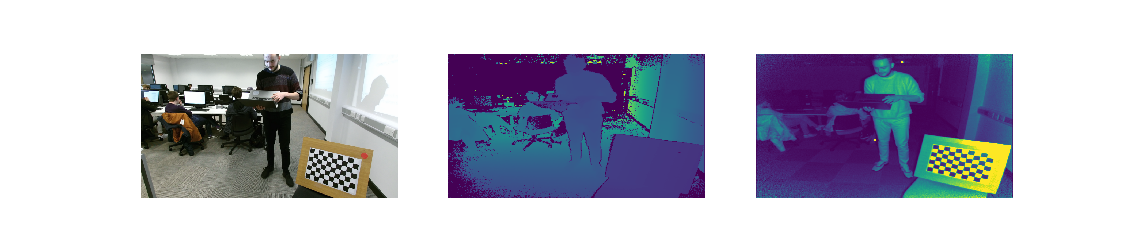

<IPython.core.display.Javascript object>


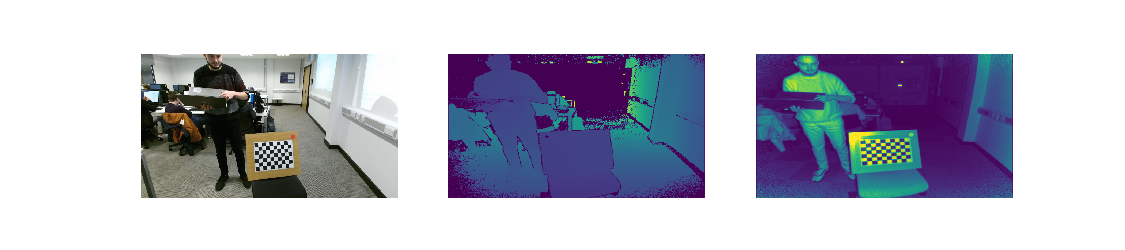

<IPython.core.display.Javascript object>


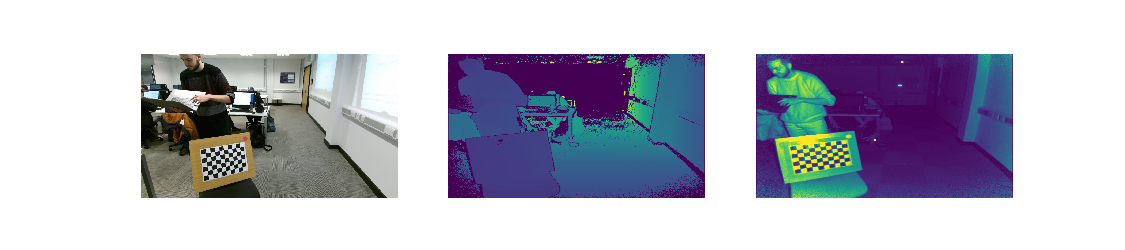

<IPython.core.display.Javascript object>


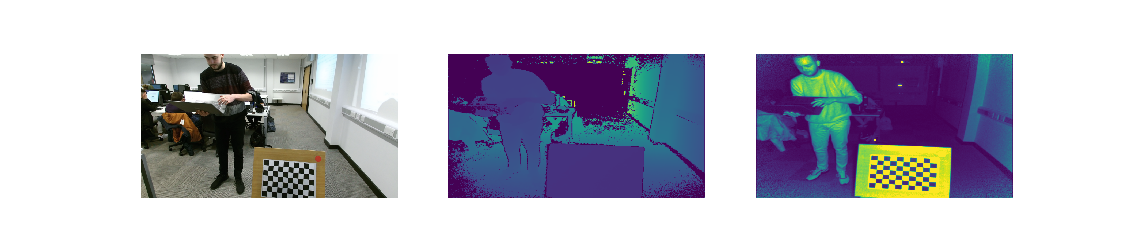

In [6]:
# Loop over our captured frames, and subplot each map 
for i_frame in range(n_frames):
    fig = plt.figure(figsize=[9, 2])
    plt.subplot(131)
    plt.imshow(img[i_frame])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(dep[i_frame])
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(infra[i_frame])
    plt.axis('off')
    plt.show(block=False)

## Detect the checkerboard pattern in an image. 
Using OpenCV, we can use the `findChessboardCorners()` method to identify a standard checkerboard pattern, commonly by identification of Harris corners. This method takes in the orignal image in grayscale, which we use `cvtColor` to achieve, and a tuple of the internal corner counts `checkerboard_pattern`.

<IPython.core.display.Javascript object>


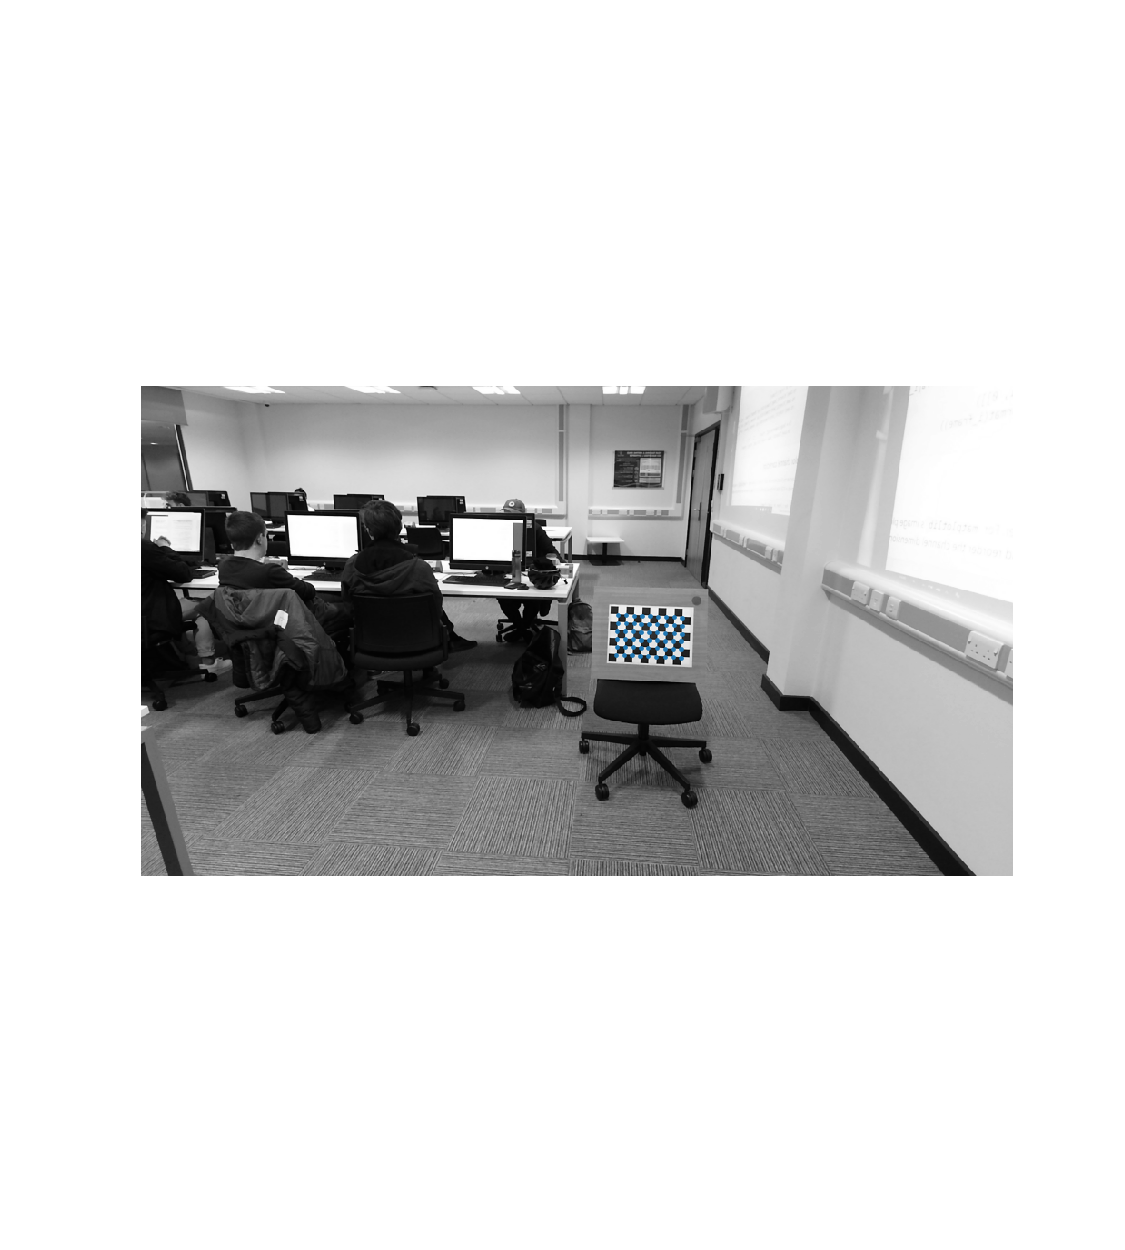

<IPython.core.display.Javascript object>


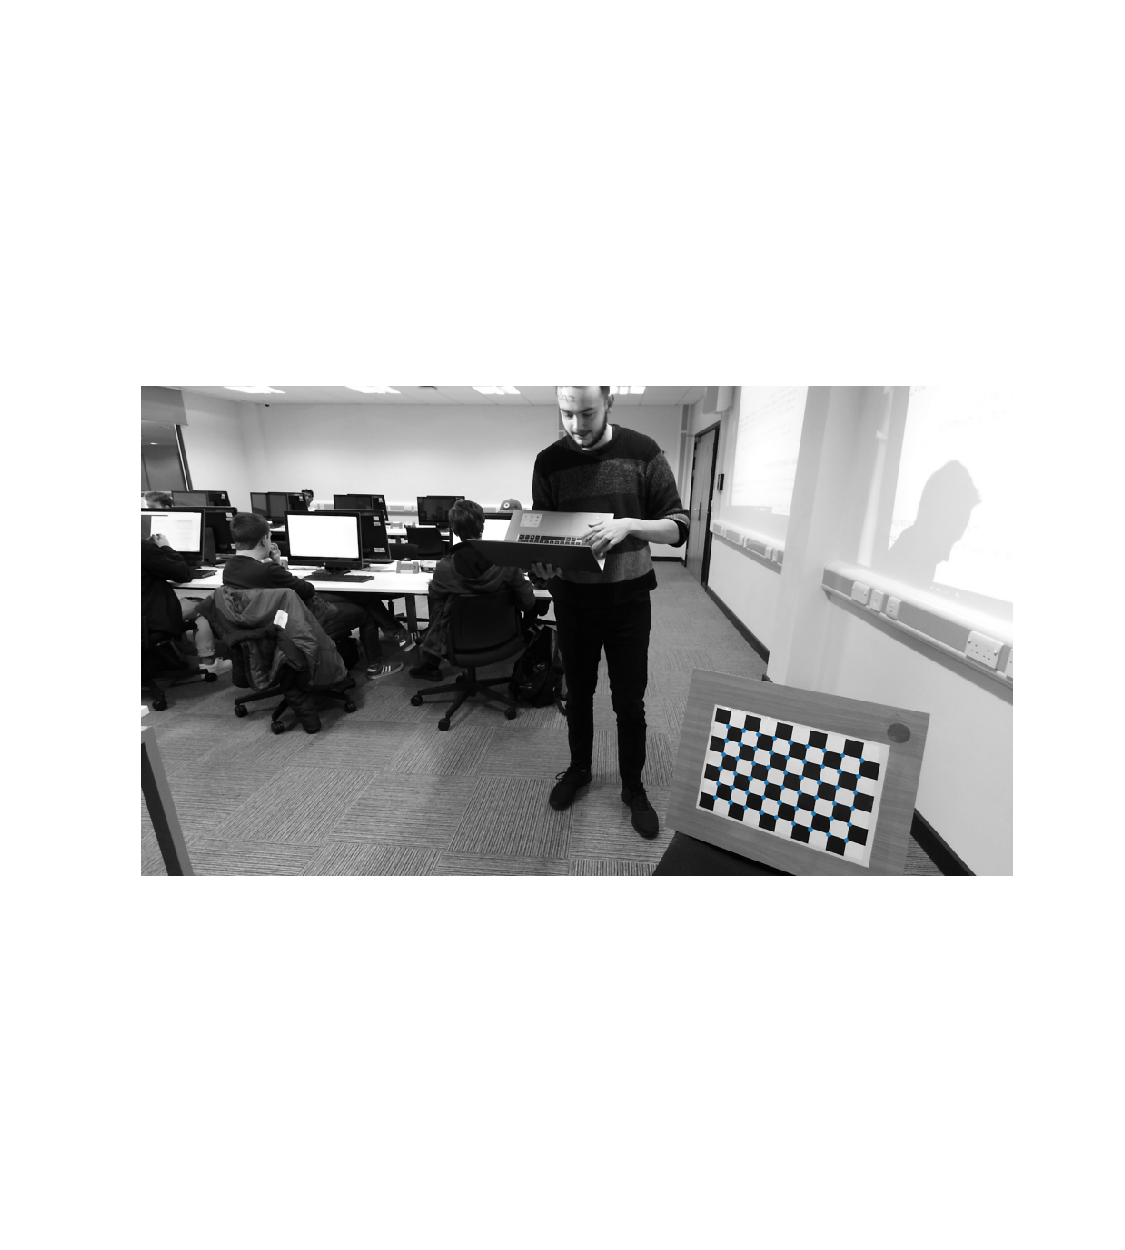

<IPython.core.display.Javascript object>


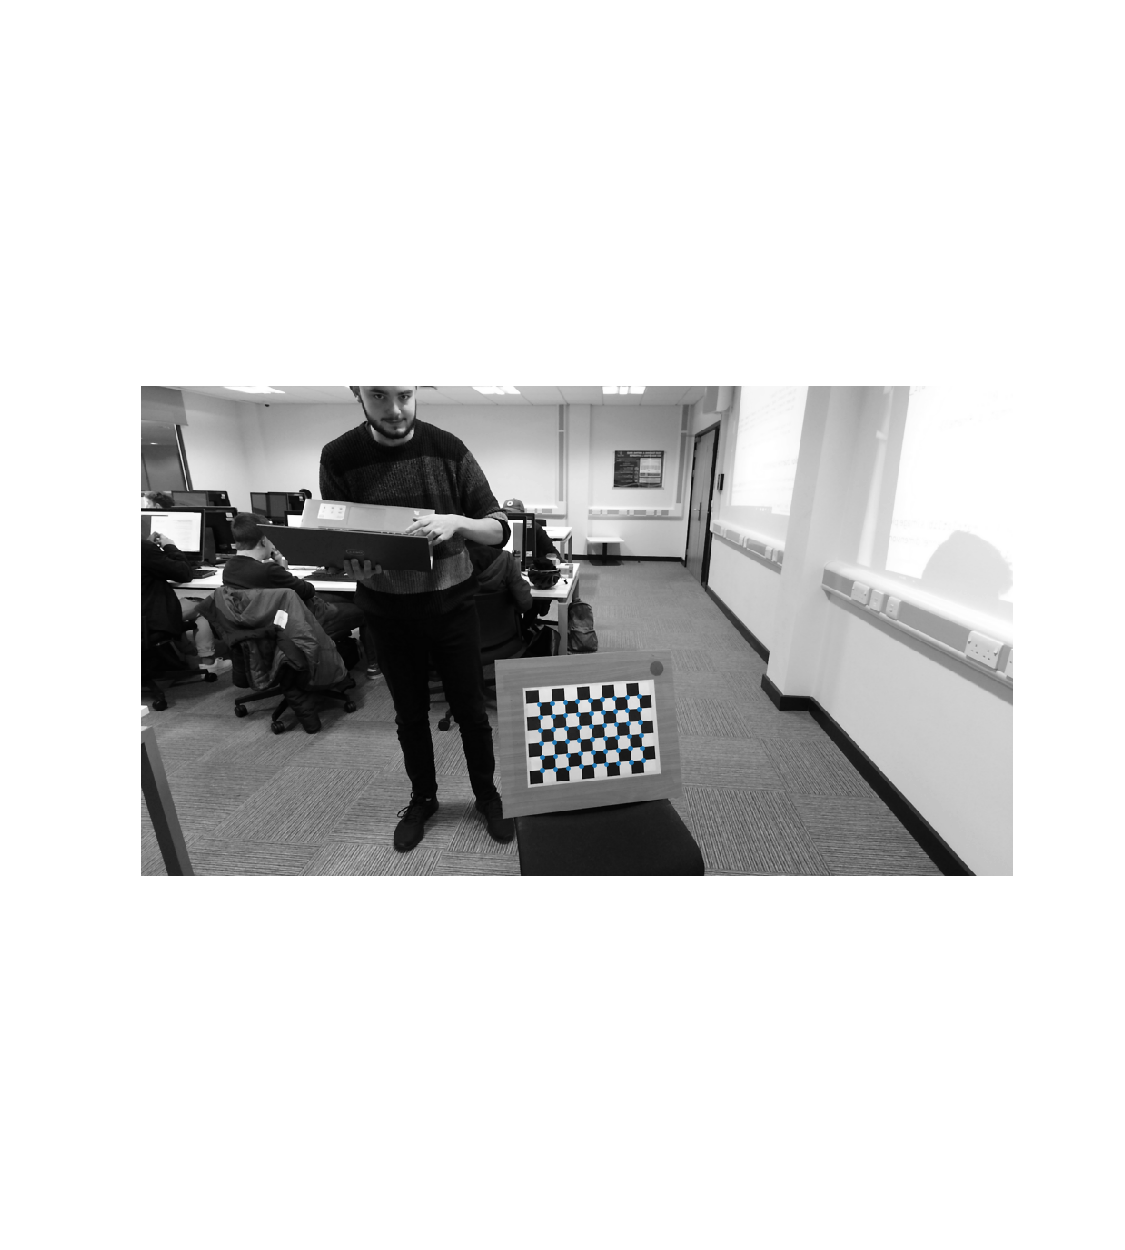

<IPython.core.display.Javascript object>


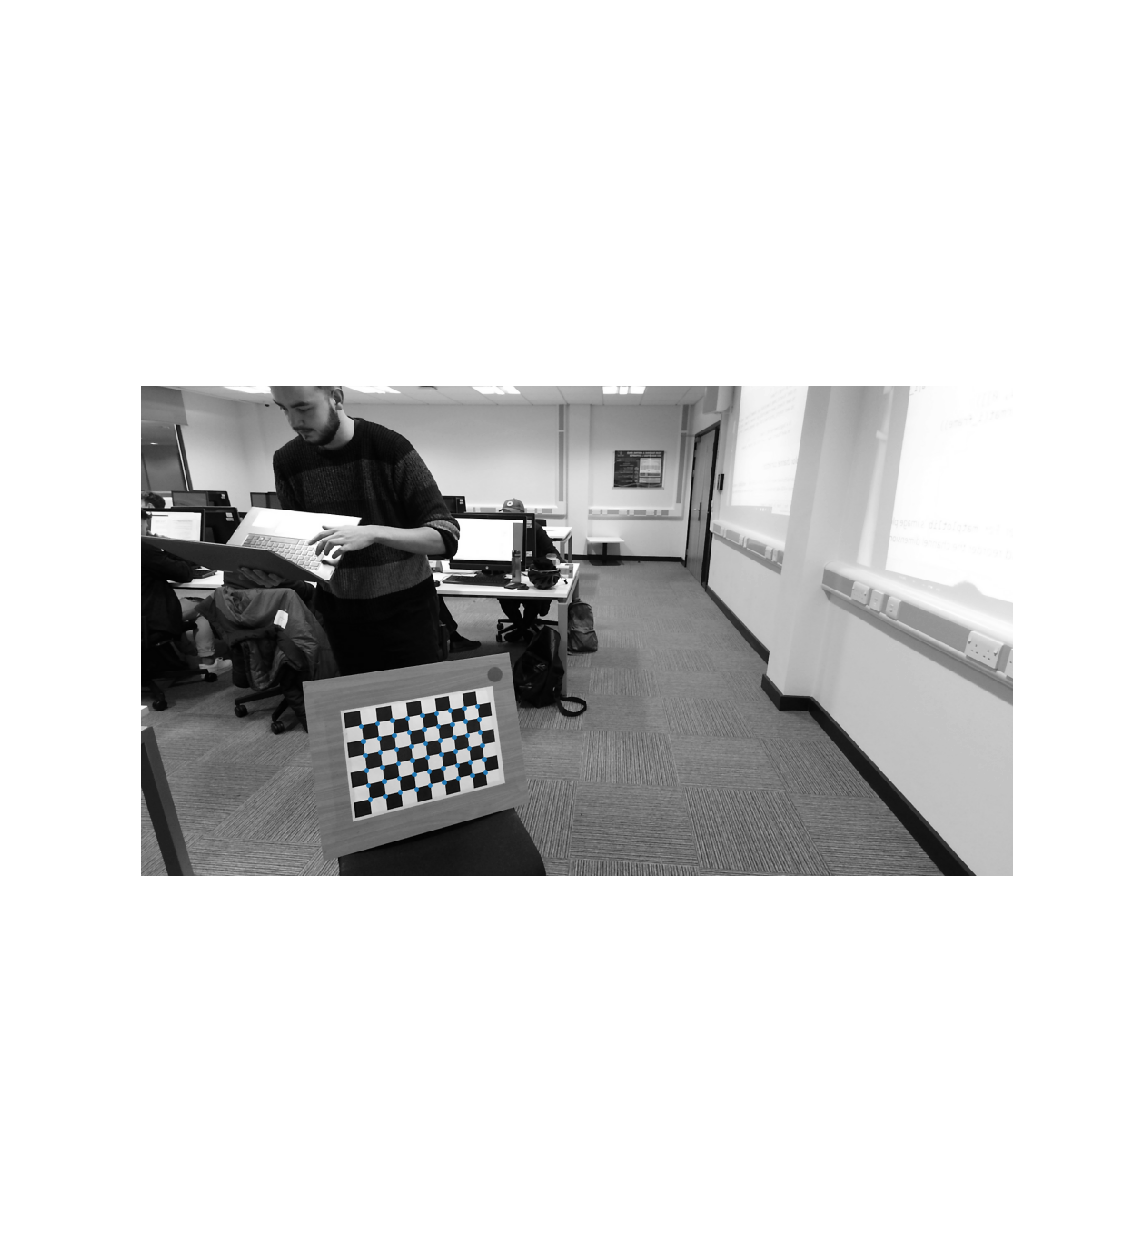

<IPython.core.display.Javascript object>


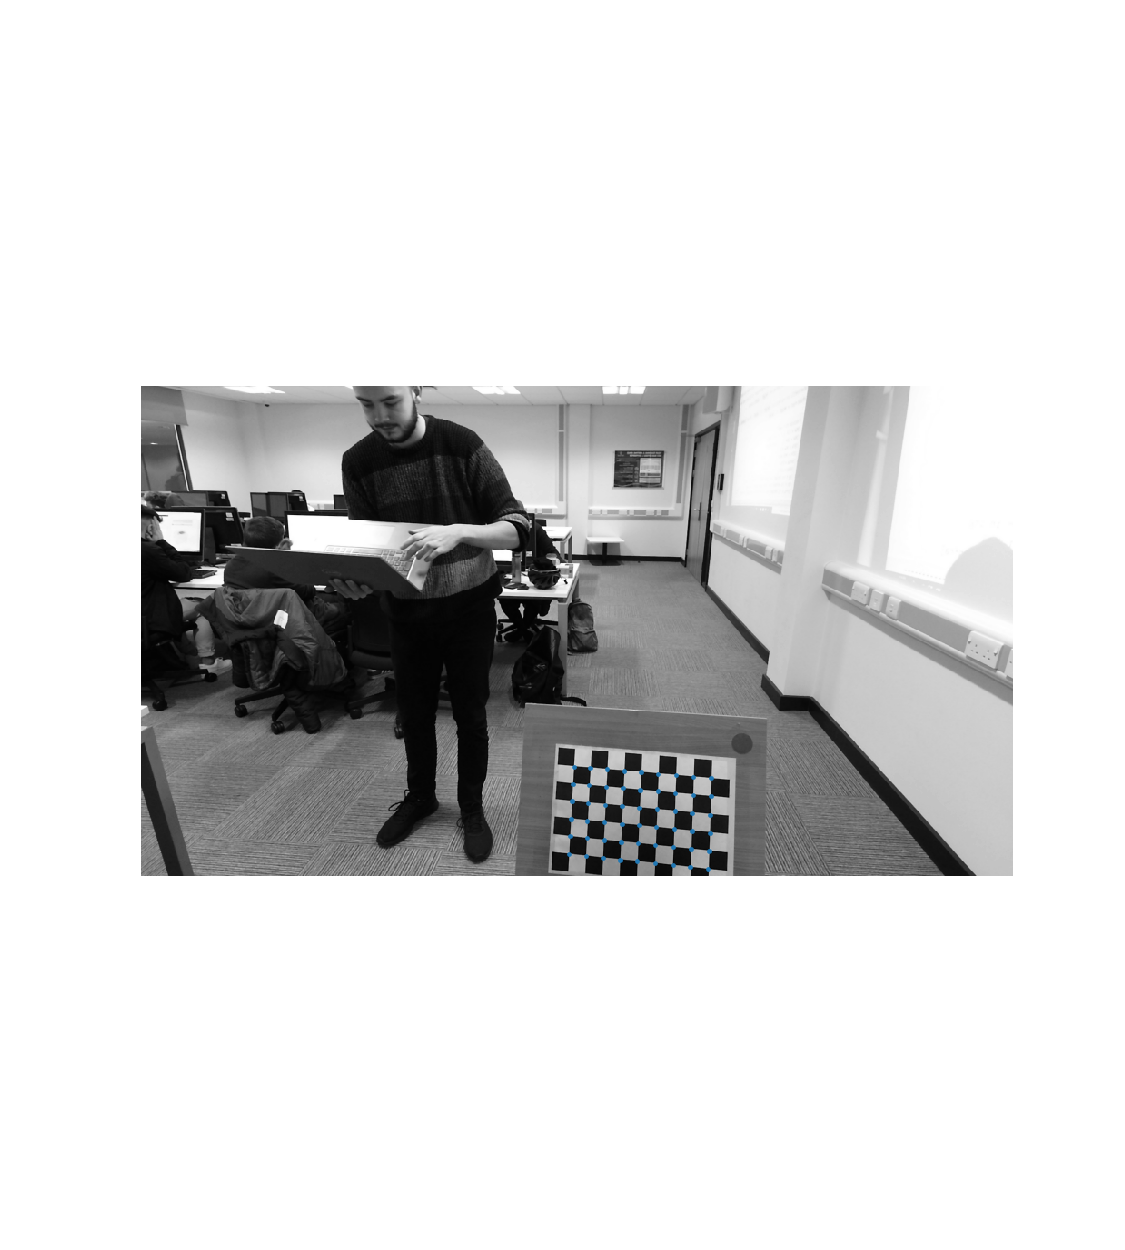

Number of successfully found patterns is: 5 out of 5


In [7]:
checkerboard_pattern = (9, 6) # This is the internal corner count
plot = True # toggle to control plotting of images

# Detect checkerboard in each image
img_corners = []
for i_frame in range(n_frames):
    
    # Detect corners in the RGB image
    image = cv2.cvtColor(img[i_frame], cv2.COLOR_BGR2GRAY) # image needs to be grayscale
    img_pattern_found, img_corner = cv2.findChessboardCorners(image, checkerboard_pattern, None) # Locate pattern in image
    
    if img_pattern_found:
        # Probably don't need to refine, but if needed then uncomment this section
        #subpixel_criteria =  (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # Stopping criteria for refinement
        #img_corner = cv2.cornerSubPix(image, img_corner, (11, 11), (-1, -1), subpixel_criteria)
        
        # Add detected corners into list for later
        img_corners.append(img_corner)
        
        if plot: 
            # plot corners over image
            plt.figure()
            plt.imshow(image, cmap='gray')
            corners = np.squeeze(img_corner)
            plt.scatter(corners[:, 0], corners[:, 1], s=3)
            plt.axis('off')
            plt.show()
            
n_boards = len(img_corners)
print('Number of successfully found patterns is: {0} out of {1}'.format(n_boards, n_frames))

## Calibrate camera using detected patterns
The following cell looks to calibrate the camera using using the identified corners from the patterns on the calibration board in each image.

First we build a coordinate system for the pattern, this requires specifying the 3D points of the corners on the board from the board's world coordinate system. For example: if we have a board of size (3, 2) we would specify corners at: 
    [[0, 0], [0, 1], [0, 2], 
     [1, 0], [1, 1], [1, 2]]

Next we use OpenCV functionality to calibrate the camera with the `calibrateCamera()` function. This returns the intrinsic camera matrix, `cam-mat`, the distortion coefficients for our camera, `distor`, and the rotation and translation vectors for each board `r_vec` and `t_vec`.

We then create a dictionary, `camera_ex`, containing the extrinsic parameters for each set of points found. This contains the rotation matrix and translation vector. Note here that we turn the rotation vectors `r_vec` into the rotation matrices `rot_mat` using the `Rodrigues()` function.

In [8]:
# Create the coordinate points of our checkerboard pattern (meshgrid makes this easier)
squareH = 40
squareW = squareH
board = np.zeros((np.product(checkerboard_pattern), 3), dtype=np.float32)
board[:, :2] = np.mgrid[0:squareH*(checkerboard_pattern[0] - 1):complex(checkerboard_pattern[0]),
                                 0:squareW*(checkerboard_pattern[1] - 1):complex(checkerboard_pattern[1])].T.reshape(-1, 2)

#Create a list of the checkerboard patterns
boards = [board for i in range(n_boards)]

# Calibrate camera
ret, cam_mat, distor, r_vec, t_vec = cv2.calibrateCamera(boards, img_corners, image.shape[::-1], None, None)

# Set up intrinsics and extrinsic parameters
camera_in = cam_mat
camera_ex = []
for i_board in range(n_boards):
    camera_ex.append({})
    camera_ex[i_board] = {'rot_mat': np.asarray(cv2.Rodrigues(r_vec[i_board])[0]),
                          'tran_mat' : np.asarray(t_vec[i_board])}    

# Translate boards to world coordinate system and plot camera centric viewpoint
In this cell we will transform the board coordinate system into the world coordinate system of the camera. We can then plot these points in the 3D space relative to our camera centred at (0, 0, 0). This makes the assumption that our camera is fixed and we move our checkerboard pattern around.

First we create our 3D matplotlib figure and plot the camera origin. We also plot 3 lines denoting the axes for this camera system.

Next we loop over our identified board patterns and translate them into the camera's world coordinate system via the rotation and translation identified via calibration.

Finally, we print these new checkerboard pattern points in the 3D space.

<IPython.core.display.Javascript object>


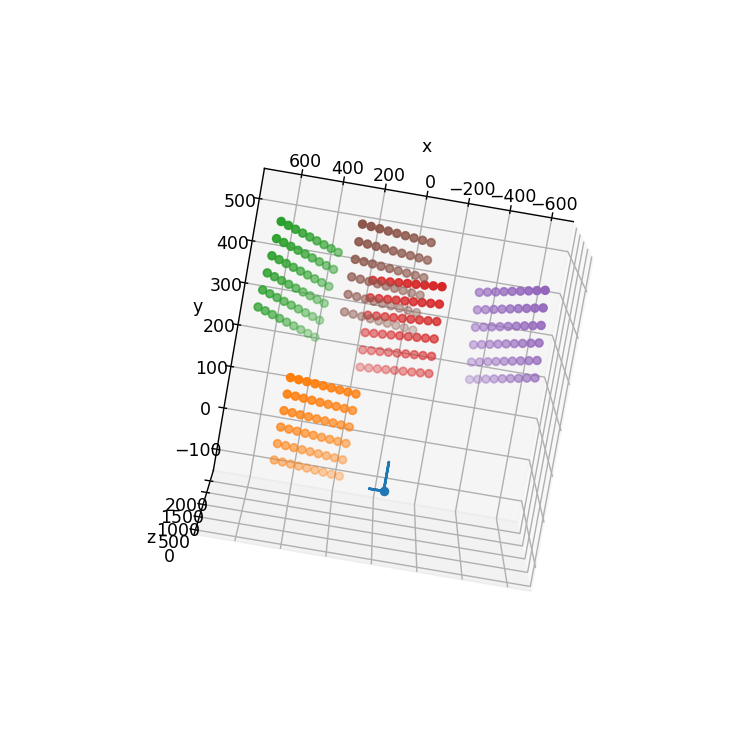

In [9]:
# Open up a 3D figure
fig3 = plt.figure(figsize=[6, 6])
ax3 = fig3.add_subplot(111, projection='3d')
ax3.scatter(0, 0, 0) # plot our camera at (0, 0, 0)
ax3.plot(np.asarray([0,  0, 0, 64, 0,   0]), # Plot 3 lines showing the 3 camera axes (X, Y, Z)
         np.asarray([0, 64, 0,  0, 0,   0]), 
         np.asarray([0,  0, 0,  0, 0, 128]))

# Perform transforms and plot for each board
world_coord_boards = []
for i_board in range(n_boards):
    # Obtain the rotation matrices and translation vectors from the extrinsic parameters for each board
    R = camera_ex[i_board]['rot_mat']
    T = np.squeeze(camera_ex[i_board]['tran_mat'])
    
    # Perform the rotation and translation of the boards relative to the camera centred at origin: Rx+T
    corners_world = np.matmul(R, board.T).T
    corners_world += T
    world_coord_boards.append(corners_world)
    
    # Plot our board corners in 3D
    ax3.scatter(xs=world_coord_boards[-1][:, 0], ys=world_coord_boards[-1][:, 1], zs=world_coord_boards[-1][:, 2])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('z')
    plt.show(block=False)

# Translate cameras and plot the pattern centric viewpoints
In this cell we will transform the camera coordinate system into the world coordinate system of the board. We can then plot these points in the 3D space relative to our board centred at (0, 0, 0). This makes the assumption that our pattern is fixed and we move our camera around.

First we create our 3D matplotlib figure and plot the board pattern at origin. We also plot 3 lines denoting the axes for this board system.

Next we loop over each camera viewpoint in our identified board patterns and translate them into the board's world coordinate system via the inversed of the translation and rotation identified via calibration.

Finally, we print these new camera positions and orientations in the 3D space.

<IPython.core.display.Javascript object>


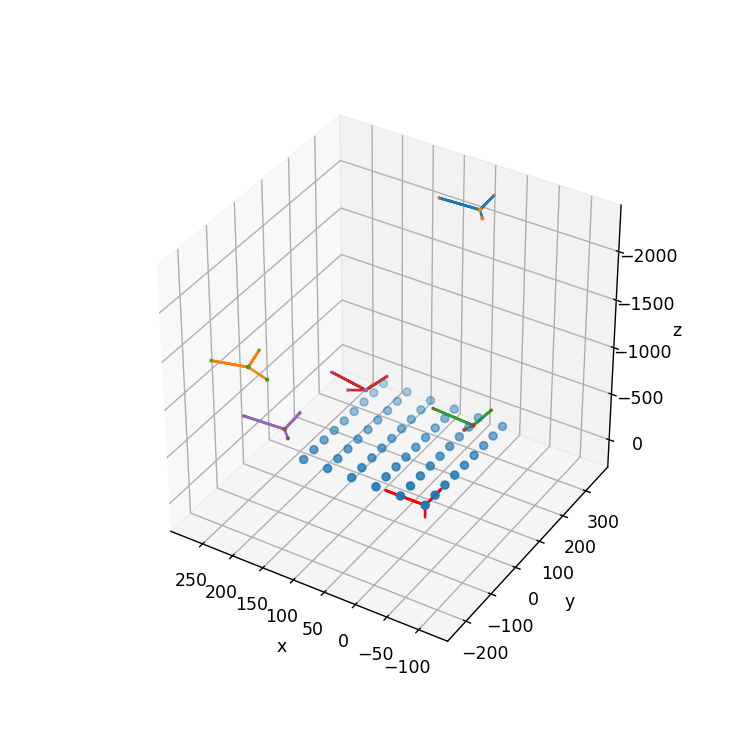

In [10]:
# Open up a 3D figure
fig3 = plt.figure(figsize=[6, 6])
ax3 = fig3.add_subplot(111, projection='3d')
ax3.scatter(board[:, 1], board[:, 0], board[:, 2])# plot our board at (0, 0, 0)
ax3.plot(np.asarray([0,  0, 0, 64, 0,   0]), # Plot 3 lines showing the 3 board axes (X, Y, Z)
         np.asarray([0, 64, 0,  0, 0,   0]), 
         np.asarray([0,  0, 0,  0, 0, 128]),'r')

# Create coordinates for camera axes plots, these will be translated and rotated into the board-centric world
cam_axes = np.asarray([[0,  0, 0, 64, 0,  0],
                       [0, 64, 0,  0, 0,  0],
                       [0,  0, 0,  0, 0, 64]]).T

# Perform transforms and plot for each camera
camera_positions = []
for i_camera in range(n_boards): # R'(x-T)
    # Obtain the rotation matrices and translation vectors from the extrinsic parameters for each board
    R = camera_ex[i_camera]['rot_mat']
    T = np.squeeze(camera_ex[i_camera]['tran_mat'])
    
    # Perform the rotation and translation of the boards relative to the camera centred at origin: R'(x-T)
    new_cam_axes = cam_axes - T
    new_cam_axes = np.matmul(R.T, new_cam_axes.T).T
    camera_positions.append(new_cam_axes)

    # Plot cameras
    ax3.scatter(xs=camera_positions[-1][:, 0], ys=camera_positions[-1][:, 1], zs=camera_positions[-1][:, 2], s=2)
    ax3.plot(camera_positions[-1][:, 0], camera_positions[-1][:, 1], camera_positions[-1][:, 2])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('z')
    plt.show(block=False)